In [295]:
import pandas as pd
import numpy as np
import sqlite3
import json
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Thanks StackOverflow!
# https://stackoverflow.com/questions/21137150/format-suppress-scientific-
#         notation-from-python-pandas-aggregation-results
pd.options.display.float_format = '{:.2f}'.format

In [4]:
cd '/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/analysis'

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/analysis


In [21]:
conn = sqlite3.connect('movie_analysis.db')
cur = conn.cursor()

In [425]:
# Source: https://pbpython.com/effective-matplotlib.html

# {:1.1f} in this case means: apply format to the first 1 instance
# that value should be presented with .1f = as a float with 1 point precision
# change the second number to increase or decrease precision

def currency(x, pos):
    'The two args are the value and tick position'
    if abs(x) >= 1000000000:
        return '${:1.1f} B'.format(x*1e-9)
        return '${:1.1f} B'.format(x*1e-9)
    elif abs(x) >= 1000000:
        return '${:1.1f} M'.format(x*1e-6)
    elif x == 0:
        return '${:0}'.format(x)
    else:
        return '${:1.0f} K'.format(x*1e-3)

# Topic 1: Profitability Trends

## Create dataframe with relevant films for financial analysis

In [169]:
# I think this the most accurate representation of movies created by American
# production studios, using films associated with US production studios.
# After further analysis, also added movies that had English as original_language,
# which means this includes some english films produced by studios outside the US.
# Finally, limited to films with runtime over 60 mins, as was pulling in shorter
# films that may have a different audience.

sql2 = """SELECT DISTINCT m.id
                        , m.budget
                        , m.revenue
                        , m.release_date
                        , m.original_language
                        , m.imdb_id
                        , m.runtime
                        , m.vote_average
                        , m.vote_count
         FROM tmdb_movies m
         WHERE ((
                (m.id IN (SELECT DISTINCT pc.id 
                          FROM tmdb_movie_companies pc
                          INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
                          WHERE c.origin_country = 'US'))
            OR  (m.original_language = 'en')
               )
            AND (m.runtime > 60))
               
         """

df = pd.DataFrame(cur.execute(sql2).fetchall(),columns=[x[0] for x in cur.description])

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56380 entries, 0 to 56379
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 56380 non-null  int64  
 1   budget             10850 non-null  float64
 2   revenue            8302 non-null   float64
 3   release_date       56366 non-null  object 
 4   original_language  56380 non-null  object 
 5   imdb_id            55699 non-null  object 
 6   runtime            56380 non-null  float64
 7   vote_average       56380 non-null  float64
 8   vote_count         56380 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 3.9+ MB


In [171]:
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count
count,56380.00,10850.00,8302.00,56380.00,56380.00,56380.00
mean,204081.74,19779143.19,69814223.57,98.20,5.53,227.69
std,204595.92,34357146.86,157088846.86,41.35,2.00,1076.63
min,5.00,1.00,1.00,61.00,0.00,0.00
25%,38384.75,1000000.00,1918387.00,85.00,4.90,4.00
50%,112507.00,6000000.00,15128146.50,92.00,6.00,11.00
75%,339535.50,23000000.00,64778551.25,103.00,6.70,46.00
max,804762.00,380000000.00,2797800564.00,5220.00,10.00,28618.00


In [109]:
# Replace 0 with NULL values for budget, revenue, and runtime columns
# Do in SQL so don't have to redo each time unless added new data

sql4 = """UPDATE tmdb_movies
          SET budget = NULL WHERE budget = 0"""
sql5 = """UPDATE tmdb_movies
          SET revenue = NULL WHERE revenue = 0"""
sql6 = """UPDATE tmdb_movies
          SET runtime = NULL WHERE runtime = 0"""
sql7 = """UPDATE tmdb_movies
          SET release_date = NULL WHERE release_date = ''"""

#cur.execute(sql4)
#cur.execute(sql5)
#cur.execute(sql6)
#cur.execute(sql7)

conn.commit()

In [ ]:
# Looks like we have 14 films where our release_date is empty string
df['release_date'].map(lambda x: len(x)).value_counts()

In [123]:
# Take a look at just the non-nulls
df[df['release_date'].isna()==False]['release_date'].map(lambda x: len(x)).value_counts()

10    56366
Name: release_date, dtype: int64

In [174]:
# Split out year and month into new df columns
month_map = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
             7:'July',8:'August',9:'September',10:'October',11:'November',
             12:'December'}

df['release_year'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: int(x[:4]))
df['release_month'] = df[df['release_date'].isna()==False]['release_date'].map(lambda x: month_map[int(x[5:7])])

df.loc[df['release_year'].isna()==True, 'release_year'] = 0
df['release_year'] = df['release_year'].astype(int)

Before calculating profitability, want to adjust the numbers for inflation. Retrieved the Consumer Price Index from http://www.bls.gov/ using the instructions here: https://www.maa.org/press/periodicals/loci/joma/the-consumer-price-index-and-inflation-get-cpi-data-from-the-web-and-into-a-spreadsheet

In [182]:
cd '/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data'

/Users/jessicamiles/Documents/Flatiron_Data_Science/git_labs_lessons/phase1/dsc-phase-1-project/data


In [279]:
# Read in Consumer Price Index info from CSV
df_cpi = pd.read_csv('Consumer Price Index.csv')

cpi_dict = pd.Series(df_cpi['Annual'].values,index=df_cpi['Year']).to_dict()

In [284]:
# Adjust budget for inflation
df['budget_2020adj'] = df[(df['budget'].isna()==False) & (df['budget'] > 0)
       ][['budget', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]], axis=1)


KeyError: 2022.0

In [275]:
# Adjust revenue for inflation
df['revenue_2020adj'] = df[(df['revenue'].isna()==False) & (df['revenue'] > 0)
       ][['revenue', 'release_year']].apply(
        lambda x : (x[0] * cpi_dict[2020]) / cpi_dict[x[1]]
                                           , axis=1)

In [286]:
# Calculate profit with inflation-adjusted values
df['profit_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(lambda x : (x[0] - x[1]), axis=1)

In [291]:
# Calculate % profit with inflation-adjusted values
df['profitpercent_2020adj'] = df[(df['revenue_2020adj'].isna()==False) 
                      & (df['budget_2020adj'].isna()==False)
       ][['revenue_2020adj', 'budget_2020adj']].apply(
    lambda x : ((x[0] - x[1]) / x[1]) * 100, axis=1)

In [463]:
df['profitpercent_2020adj'].describe()

count      5950.00
mean        696.33
std       17654.47
min        -100.00
25%         -27.88
50%          98.11
75%         313.12
max     1288938.67
Name: profitpercent_2020adj, dtype: float64

In [ ]:
# Create % profit categories
df.loc[df['profitpercent_2020adj']]['profit_category'] = 'Broke Even'

In [299]:
# release_decade
df['release_decade'] = df[df['release_year'] > 0]['release_year'].map(
    lambda x : int(str(x)[:3] + '0'))

df.loc[df['release_decade'].isna()==True, 'release_decade'] = 0

df['release_decade'] = df['release_decade'].astype(int)

In [306]:
df.head()

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,budget_2020adj,revenue_2020adj,profit_2020adj,profitpercent_2020adj,release_decade
0,5,4000000.00,4257354.00,1995-12-09,en,tt0113101,98.00,5.70,1901,1995,December,6792939.63,7229987.18,437047.55,6.43,1990
1,6,21000000.00,12136938.00,1993-10-15,en,tt0107286,110.00,6.50,184,1993,October,37612671.28,21738221.87,-15874449.41,-42.21,1990
2,11,11000000.00,775398007.00,1977-05-25,en,tt0076759,121.00,8.20,15257,1977,May,46978894.39,3311576461.88,3264597567.49,6949.07,1970
3,12,94000000.00,940335536.00,2003-05-30,en,tt0266543,100.00,7.80,14750,2003,May,132218663.04,1322658589.17,1190439926.13,900.36,2000
4,13,55000000.00,677387716.00,1994-07-06,en,tt0109830,142.00,8.50,20141,1994,July,96049966.26,1182964859.42,1086914893.16,1131.61,1990


OK so some of these may actually have had very low budgets (https://www.themoviedb.org/movie/1435-tarnation, for example) but it's hard to say. Some of these numbers should probably be converted to hundreds of thousands or millions, but it's impossible to tell which.

Going to limit where budget is > 10000

## Box Office Profit per Release Year

In [342]:
# Using only the data
# - release date in range 1960 to 2020
# - where we have a budget and it's greater than $10,000
# - where we have revenue

df_finance = df[(df['budget'] > 10000) & (df['revenue'].isna() == False)
   & (df['release_year'] >= 1960) & (df['release_year'] <= 2020)].copy()

In [343]:
df_finance.head()

,id,budget,revenue,release_date,original_language,imdb_id,runtime,vote_average,vote_count,release_year,release_month,budget_2020adj,revenue_2020adj,profit_2020adj,profitpercent_2020adj,release_decade
0,5,4000000.00,4257354.00,1995-12-09,en,tt0113101,98.00,5.70,1901,1995,December,6792939.63,7229987.18,437047.55,6.43,1990
1,6,21000000.00,12136938.00,1993-10-15,en,tt0107286,110.00,6.50,184,1993,October,37612671.28,21738221.87,-15874449.41,-42.21,1990
2,11,11000000.00,775398007.00,1977-05-25,en,tt0076759,121.00,8.20,15257,1977,May,46978894.39,3311576461.88,3264597567.49,6949.07,1970
3,12,94000000.00,940335536.00,2003-05-30,en,tt0266543,100.00,7.80,14750,2003,May,132218663.04,1322658589.17,1190439926.13,900.36,2000
4,13,55000000.00,677387716.00,1994-07-06,en,tt0109830,142.00,8.50,20141,1994,July,96049966.26,1182964859.42,1086914893.16,1131.61,1990


In [360]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [344]:
# How many movies do we have in our sample for each decade?
df_finance['release_decade'].value_counts()

2010    1867
2000    1783
1990    1043
1980     616
1970     212
1960     141
2020      49
Name: release_decade, dtype: int64

In [345]:
#df_recent = df_finance[(df_finance['release_year'] >= 2010) & (
#    df_finance['release_year'] < 2020)]

df_recent = df_finance[(df_finance['release_year'] >= 2010) & (
    df_finance['release_year'] <= 2020)]

### 2020 not withstanding, people DO still go to the movies.

The graph below shows median profit (box office revenue less production budget) for the last 10 years. Amounts are in 2020 US dollars, after adjustment for inflation.

The median profit for films release in 2020 is actually negative. We calculated profit using only box office revenue, and movie theaters were closed for most of 2020 due to the COVID-19 pandemic.

The 2020 results have been left as strong evidence that the data we're using to perform this analysis is representative enough to show trends. While the median profit certainly hasn't increased steadily (2013, 2016, and 2018 had some dips),  profits are generally increasing over time. 

Before the COVID-19 pandemic, box office revenues were healthy, even as original titles produced by companies--such as Amazon, Netflix and Hulu--were released directly to subscribers, bypassing theaters entirely.  



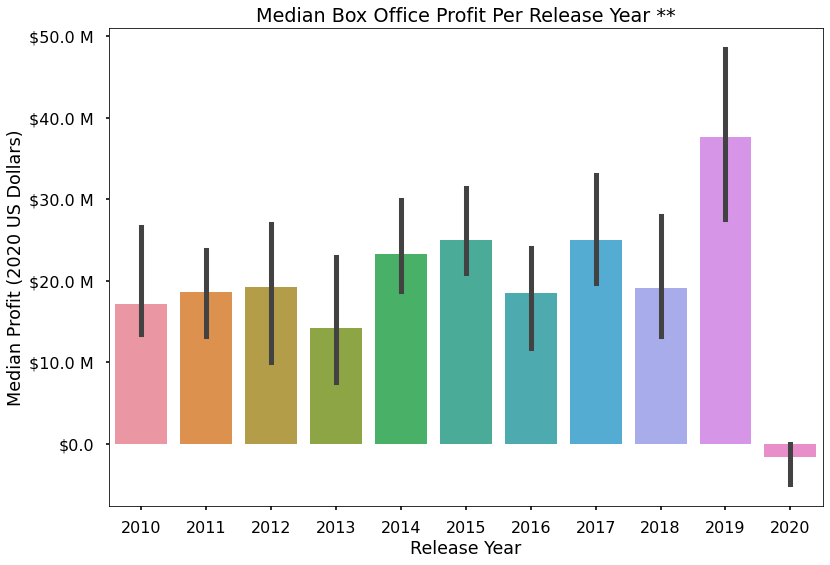

In [426]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots()

    sns.barplot(x=df_recent['release_year'], y=df_recent['profit_2020adj']
                , estimator=np.median, ax=ax, ci=68)

    ax.set_title('Median Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Median Profit (2020 US Dollars)');
    
    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))

### Many of the most profitable movies are outliers

Per the previous chart, median profit fell within a range of \\$15 MM to \\$35 MM 2020 US dollars for the past 10 years. Even the average was only around \\$100 MM.

But when we look at the distributions within each year, we see that there are many values well above that, in the many hundreds of millions, or billions of dollars. However, these are statistical outliers.

This means that while it's certainly possible to make hundreds of millions or billions of dollars at the box office on a film, that isn't a common outcome.

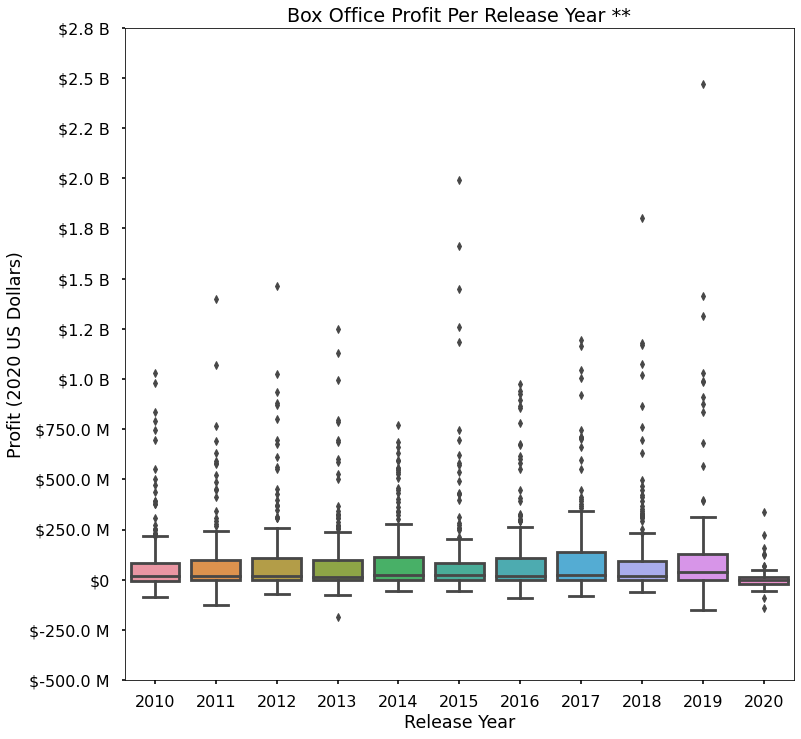

In [427]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df_recent['release_year'], y=df_recent['profit_2020adj']
                , ax=ax)
    # Source: https://pbpython.com/effective-matplotlib.html
    #ax.axhline(y=avg, color='b', label='Average', linestyle='--', linewidth=3)
#    sns.swarmplot(x=df_recent['release_year'], y=df_recent['profit_2020adj']
#                , ax=ax, size=1.5, color='black')

    ax.set_title('Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-500000000, 3000000000, 250000000));

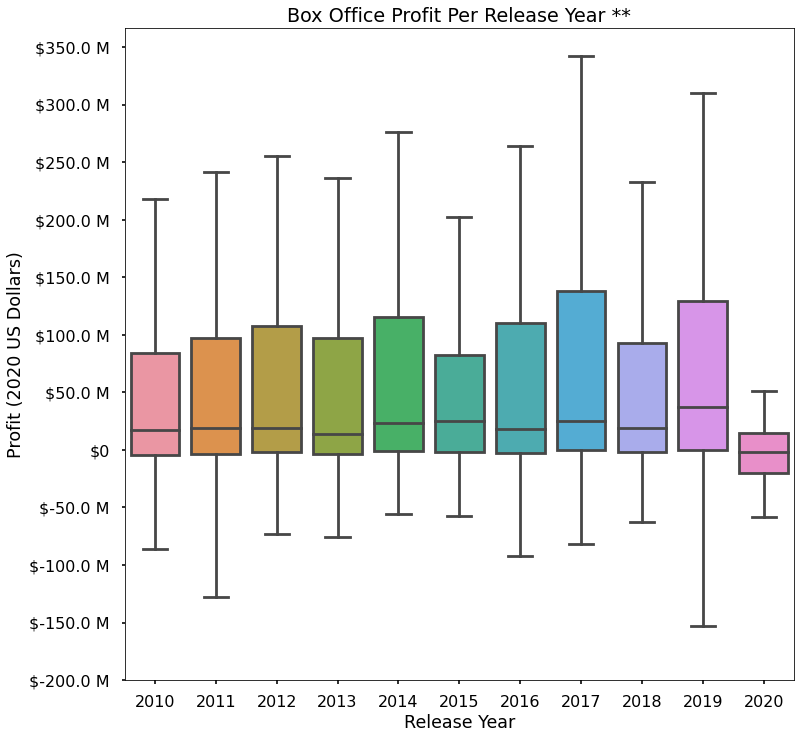

In [428]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    avg = df_recent['profit_2020adj'].mean()
    
    # Source: https://seaborn.pydata.org/generated/seaborn.boxplot.html
    sns.boxplot(x=df_recent['release_year'], y=df_recent['profit_2020adj']
                , ax=ax, showfliers=False)

    ax.set_title('Box Office Profit Per Release Year **');
    ax.set_xlabel('Release Year');
    ax.set_ylabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency))
    
    ax.set_yticks(np.arange(-200000000, 400000000, 50000000))


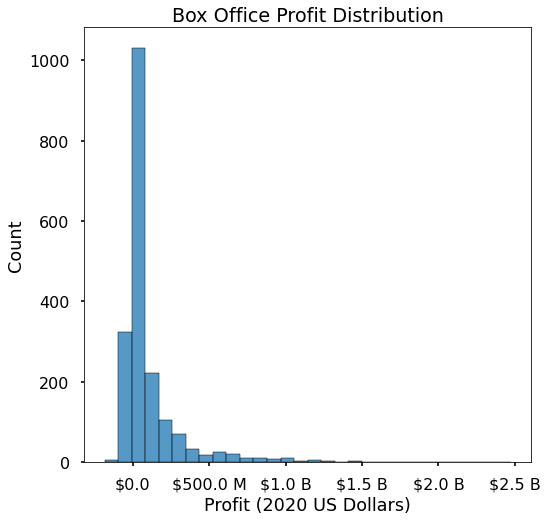

In [429]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.histplot(df_recent['profit_2020adj'], ax=ax, bins=30)
    ax.set_title('Box Office Profit Distribution');
    ax.set_xlabel('Profit (2020 US Dollars)');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))

<Figure size 576x396 with 0 Axes>

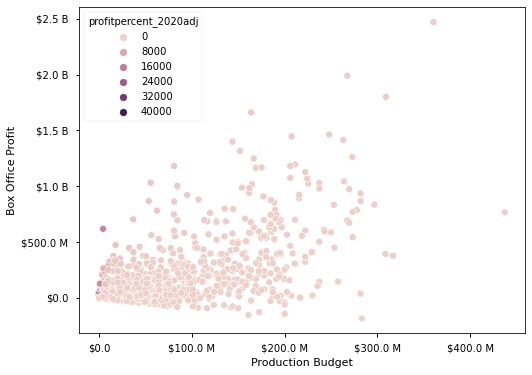

In [461]:
with plt.style.context('seaborn-notebook'):
    plt.tight_layout();
    fig, ax1 = plt.subplots(figsize=(8, 6));

    sns.scatterplot(x=df_recent['budget_2020adj'], y=df_recent['profit_2020adj']
                    , ax=ax1, hue=df_recent['profitpercent_2020adj']);
    
    #ax1.set_title('Production Budget versus Box Office Profit (2020 US Dollars)');
    ax1.set_xlabel('Production Budget');
    ax1.set_ylabel('Box Office Profit');

    #Source: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-
    #                matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(currency));
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(currency));

# Topic 2: Characteristics of Profitable Movies

# Topic 3: Impact of Contributors on Profitability

# Extra stuff

In [93]:
# So these are mostly english-language films. What production companies 
# are we talking about for english-language films that aren't associated
# with a US production company?

# These are the production companies associated with films that NO US-based
# production company worked on, and where the original_language was English

sql3 = """SELECT DISTINCT pc.id, c.name AS prodco_name, c.origin_country
          FROM tmdb_movie_companies pc
          INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
          WHERE (
                 (pc.id NOT IN (SELECT DISTINCT pc.id 
                                FROM tmdb_movie_companies pc
                                INNER JOIN tmdb_prodco c ON c.prodco_id = pc.prodco_id
                                WHERE c.origin_country = 'US'))
             AND (pc.id IN (SELECT id FROM tmdb_movies 
                            WHERE original_language='en'))
                )
              """

df3 = pd.DataFrame(cur.execute(sql3).fetchall(),columns=[x[0] for x in cur.description])

In [41]:
df3['prodco_name'].value_counts()

BBC                                 725
Universal International Pictures    200
BBC Films                           148
Hammer Film Productions             118
Canal+                              110
                                   ... 
Willowcreek Entertainment             1
From the Dead Pictures                1
Spinster                              1
New Machine Studios                   1
Cavalcade Films                       1
Name: prodco_name, Length: 22543, dtype: int64

In [28]:
df2['original_language'].value_counts()

en    24795
es       78
fr       75
ja       62
it       59
de       50
pt       29
zh       25
hi       14
ko       11
ru       10
xx        9
he        8
id        6
cn        5
sv        5
tr        4
ar        4
nl        4
ro        3
el        3
da        3
uk        2
th        2
pl        2
tl        1
et        1
no        1
hu        1
ak        1
se        1
fa        1
ml        1
ca        1
ab        1
Name: original_language, dtype: int64

In [ ]:
#Ultimately, I think I want the deduplicated union of both these sets.
# This represents all movies which were either 